
# Human Emotion Detection using CNN

This notebook demonstrates the implementation of a **Convolutional Neural Network (CNN)** for **human emotion detection** 
from facial images. The dataset used contains different categories of emotions such as **happy, sad, angry, fear, surprise, 
neutral, and disgust**.

The notebook covers the following steps:

- Importing libraries  
- Loading and preprocessing the dataset  
- Building a CNN model using TensorFlow/Keras  
- Training and validating the model  
- Visualizing accuracy/loss curves  
- Evaluating performance with a confusion matrix & classification report  

This is a **learning-focused project** that demonstrates understanding of CNN basics applied to a real-world task 
of facial emotion recognition.


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout,BatchNormalization


In [ ]:
traindata=tf.keras.preprocessing.image_dataset_from_directory(
    directory="/Dataset/HES/train",
    labels='inferred',
    label_mode='categorical',
    class_names=["angry", "disgust","fear","happy", "neutral", "sad", "surprise"],
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
    validation_split=0.2 ,
    subset='training',
    
)
valdata=tf.keras.preprocessing.image_dataset_from_directory(
    directory="/Dataset/HES/train",
    labels='inferred',
    label_mode='categorical',
    class_names=["angry", "disgust","fear","happy", "neutral", "sad", "surprise"],
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
    validation_split=0.2 ,
    subset='validation',
)
testdata=tf.keras.preprocessing.image_dataset_from_directory(
    directory="/Dataset/HES/test",
    labels='inferred',
    label_mode='categorical',
    class_names=["angry", "disgust","fear","happy", "neutral", "sad", "surprise"],
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)


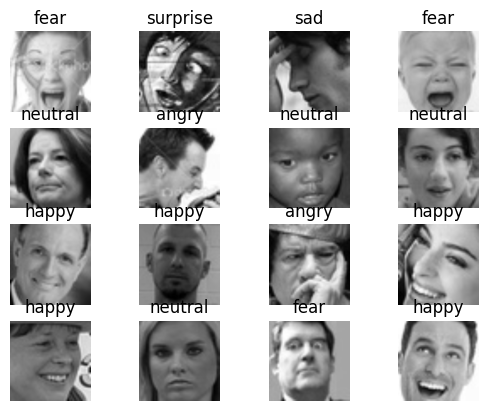

In [3]:
CLASS_NAMES=["angry", "disgust","fear","happy", "neutral", "sad", "surprise"]
for image, label in traindata.take(1):
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(image[i]/255.0)
        
        plt.title(CLASS_NAMES[tf.argmax(label[i])])
        plt.axis("off")

In [4]:
traindata=traindata.prefetch(buffer_size=tf.data.AUTOTUNE)
valdata=valdata.prefetch(buffer_size=tf.data.AUTOTUNE)
testdata=testdata.prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
resize_and_rescale=tf.keras.Sequential([
    tf.keras.layers.Resizing(256,256),
    tf.keras.layers.Rescaling(1./255)
])

In [ ]:
lennet_model=model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(244, 244, 3)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(7, activation='softmax')   # 7 classes in FER2013
])

lennet_model.build(input_shape=(None, 256, 256, 3))
lennet_model.summary()

In [ ]:
lennet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  
    metrics=['accuracy']
)

In [ ]:
history=lennet_model.fit(traindata,validation_data=valdata,epochs=20)

In [10]:
lennet_model.save("lennet_model.h5")

In [8]:
lennet_model=tf.keras.models.load_model("lennet_model.h5")

In [ ]:
lennet_model.evaluate(testdata)

In [ ]:
for image, label in testdata.take(1):
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(image[i]/255.0)
        
        pred = lennet_model.predict(tf.expand_dims(image[i], axis=0))
        pred_class = CLASS_NAMES[np.argmax(pred)]
        true_class = CLASS_NAMES[tf.argmax(label[i])]
        plt.title(f"True: {true_class}\nPred: {pred_class}")
        plt.axis("off")

In [40]:
def create_example(image, image_label):
    image_feature = tf.train.Feature(bytes_list=tf.train.BytesList(value=[image]))
    label_feature = tf.train.Feature(int64_list=tf.train.Int64List(value=[image_label]))
    feature = {'image': image_feature, 'label': label_feature}
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()
    

In [49]:
def encoder(image, label):
    image=tf.image.convert_image_dtype(image, tf.uint8)
    image=tf.io.encode_jpeg(image)
    return image.numpy(), label.numpy()

In [52]:
encoded_data = traindata.unbatch().map(lambda x,y: tf.py_function(encoder, [x,y], [tf.string, tf.int64]))

In [ ]:
NUM_SHARDS=10
PATH="/HES_shards/tfrecord{:05d}.tfrecord"
for i in range(NUM_SHARDS):
    sharded_image = encoded_data.shard(NUM_SHARDS, i)

    with tf.io.TFRecordWriter(PATH.format(i)) as writer:
        for image, label in sharded_image:
            
            example = create_example(image_bytes, label_int)
            writer.write(example)

In [25]:
recon_data=tf.data.TFRecordDataset(filenames=[PATH.format(i) for i in range(NUM_SHARDS)])
def parse_features(example):
    Feature={
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    example=tf.io.parse_single_example(example,Feature)
    example['image']=tf.image.decode_jpeg(example['image'], channels=3)
    return example['image'], example['label']



In [ ]:
data_f=recon_data.map(parse_features).batch(32).prefetch(tf.data.AUTOTUNE)
data_f.take(1)


## Training Visualization

Let's plot training and validation accuracy and loss across epochs.


In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



## Model Evaluation

We will evaluate the model using a confusion matrix and classification report.


In [ ]:

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Predictions
y_pred = model.predict(testdata)
y_pred_classes = np.argmax(y_pred, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Confusion Matrix
cm = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, y_pred_classes))



## Conclusion

- A CNN was built and trained for **human emotion detection** using Keras.  
- The model learned to classify facial images into different emotion categories such as happy, sad, angry, etc.  
- Training/validation accuracy and loss curves show the learning progress.  
- Confusion matrix and classification report provide deeper insights into how well each emotion is recognized.  

This project highlights fundamental deep learning skills, including **data preprocessing, CNN model design, training visualization, 
and evaluation for emotion recognition**.  

Future improvements can be made using **data augmentation, dropout, and transfer learning (e.g., MobileNet, VGG, ResNet)** to improve accuracy.
